# Data
## First approaches
### Imagery (Surface Reflectance)

In [ ]:
# description: https://www.usgs.gov/landsat-missions/landsat-collection-2-surface-reflectance
# metadata: https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/media/files/LSDS-1618_Landsat-4-7_C2-L2-ScienceProductGuide-v4.pdf

In [1]:
import xarray as xr
import rioxarray as rxr

In [58]:
red = rxr.open_rasterio("/Users/felixschulz/Library/CloudStorage/OneDrive-Persönlich/Dokumente/Uni/Master Thesis/data/imagery/landsat/Landsat 4-5 TM Collection 2 Level-2/LT05_L2SP_175084_19840609_20200918_02_T1/LT05_L2SP_175084_19840609_20200918_02_T1_SR_B4.TIF")
green = rxr.open_rasterio("/Users/felixschulz/Library/CloudStorage/OneDrive-Persönlich/Dokumente/Uni/Master Thesis/data/imagery/landsat/Landsat 4-5 TM Collection 2 Level-2/LT05_L2SP_175084_19840609_20200918_02_T1/LT05_L2SP_175084_19840609_20200918_02_T1_SR_B3.TIF")
blue = rxr.open_rasterio("/Users/felixschulz/Library/CloudStorage/OneDrive-Persönlich/Dokumente/Uni/Master Thesis/data/imagery/landsat/Landsat 4-5 TM Collection 2 Level-2/LT05_L2SP_175084_19840609_20200918_02_T1/LT05_L2SP_175084_19840609_20200918_02_T1_SR_B2.TIF")

In [ ]:
scaled_red = xr.where(red != 0, (red - 1) / (65535 - 1), 0)
scaled_green = xr.where(green != 0, (green - 1) / (65535 - 1), 0)
scaled_blue = xr.where(blue != 0, (blue - 1) / (65535 - 1), 0)

In [61]:
test = xr.combine_nested([green, red, blue], concat_dim = "band")

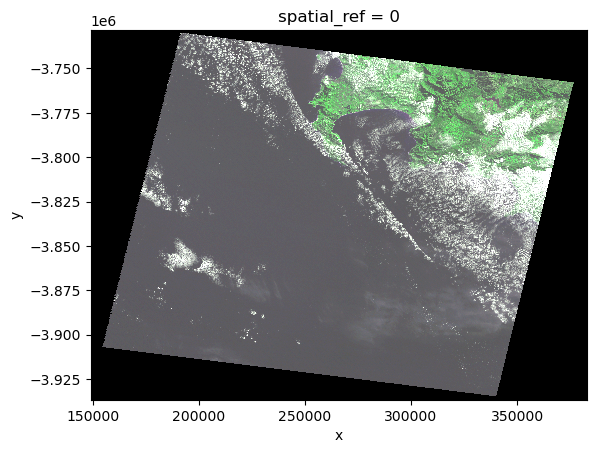

In [62]:
xr.plot.imshow(test, rgb = "band", robust = True)

In [63]:
cloud = rxr.open_rasterio("/Users/felixschulz/Library/CloudStorage/OneDrive-Persönlich/Dokumente/Uni/Master Thesis/data/imagery/landsat/Landsat 4-5 TM Collection 2 Level-2/LT05_L2SP_175084_19840609_20200918_02_T1/LT05_L2SP_175084_19840609_20200918_02_T1_SR_CLOUD_QA.TIF")

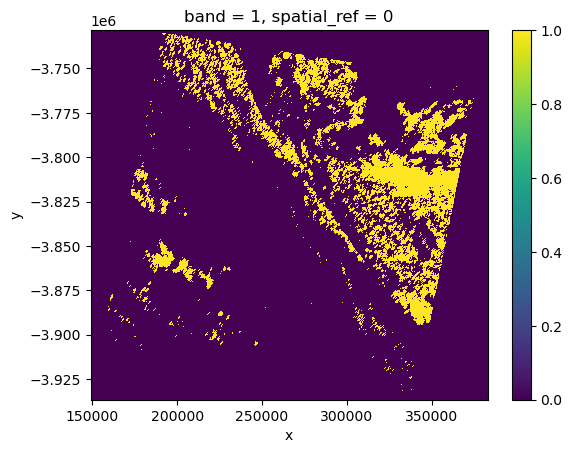

In [70]:
cloud.squeeze().isin([2, 34, 4, 12, 20, 36, 52, 8, 12, 24, 40, 56]).plot.imshow()

In [71]:
cloud_dist = rxr.open_rasterio("/Users/felixschulz/Library/CloudStorage/OneDrive-Persönlich/Dokumente/Uni/Master Thesis/data/imagery/landsat/Landsat 4-5 TM Collection 2 Level-2/LT05_L2SP_175084_19840609_20200918_02_T1/LT05_L2SP_175084_19840609_20200918_02_T1_ST_CDIST.TIF")

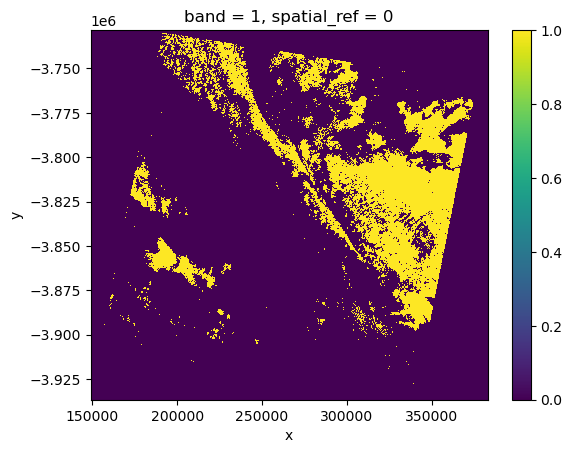

In [76]:
((cloud_dist.squeeze() > -5000) & (cloud_dist.squeeze() <= .1)).plot.imshow()

In [84]:
red_filtered = red.squeeze().where(cloud_dist.squeeze() > .1)

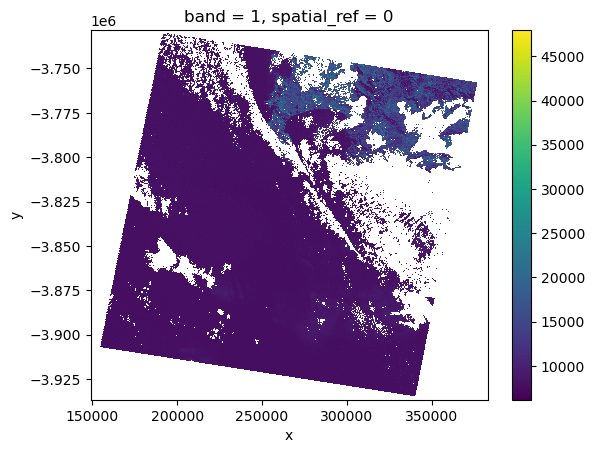

In [85]:
red_filtered.plot.imshow()

#### API

In [1]:
import requests
import geopandas as gpd
import shapely
import time

/scratch/slurm_tmpdir/job_22155403/ipykernel_426352/2390097053.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
with open("data/api_creds", "r") as file:
    exec("creds = " + file.read())

In [3]:
# login
response = requests.post("https://m2m.cr.usgs.gov/api/api/json/stable/login",
                         json = creds)
API_key = response.json()["data"]

In [41]:
response = requests.post("https://m2m.cr.usgs.gov/api/api/json/stable/download-retrieve",
                        headers = {"X-Auth-Token": API_key}) 

In [48]:
for y in [x["downloadId"] for x in response.json()["data"]["requested"]][1:]:
    requests.post("https://m2m.cr.usgs.gov/api/api/json/stable/download-remove",
                        json = {"downloadId": y},
                        headers = {"X-Auth-Token": API_key}) 

In [5]:
# get all datasets
response = requests.post("https://m2m.cr.usgs.gov/api/api/json/stable/dataset-search",
                         headers = {"X-Auth-Token": API_key})

In [4]:
([{x["collectionName"]: x["datasetAlias"]} for x in response.json()["data"]])[1000:]

[{'Aerial Photo Single Frames': 'aerial_combin'},
 {'Aircraft Scanners': 'aircraft_scanners'},
 {'Algeria 3': 'calval_pis_algeria_3'},
 {'Algeria 5': 'calval_pis_algeria_5'},
 {'Antarctic Flight Line Maps': 'aerial_usarc_index'},
 {'Antarctic Single Frames': 'aerial_usarc'},
 {'ASAS': 'asas'},
 {'ASTER GED AG100': 'aster_ged_ag100'},
 {'ASTER GED AG1KM': 'aster_ged_ag1km'},
 {'ASTER GED AG5KMMOH V41': 'aster_ged_ag5kmmoh'},
 {'ASTER GED C2 Subset': 'atmo_aux_aster_ged'},
 {'ASTER Global DEM V3': 'aster_global_dem_v3'},
 {'ASTER Level 1T V3': 'aster_l1t'},
 {'ASTER Water Bodies Database V1': 'astwbd'},
 {'AVHRR Composites': 'avhrr_composite'},
 {'AVHRR Global 1K': 'avhrr_1k_global_comp'},
 {'AVHRR Orbital Segment': 'avhrr_orbseg'},
 {'AVHRR Phenology': 'avhrr_phen_metrics'},
 {'CAM5K30CF V2': 'cam5k30cf_v2'},
 {'CAM5K30EM V2': 'cam5k30em_v2'},
 {'CAM5K30UC V2': 'cam5k30uc_v2'},
 {'CCDC V1.0 (HI)': 'ccdc_v1_0_hi'},
 {'CCDC V1.1 (CONUS)': 'ccdc_v1_1'},
 {'CCDC V1.2 (CONUS)': 'ccdc_v1_2'},

In [37]:
# get all scenes
scene_list = []
it_starting_number = 0
it_next_record = 1001
it_total_hits = 0
while (it_total_hits != it_next_record):
    time.sleep(1)
    # do the API request
    response = requests.post("https://m2m.cr.usgs.gov/api/api/json/stable/scene-search",
                            json = {"datasetName": "landsat_etm_c2_l2",
                                    "maxResults": 1000,
                                    "startingNumber": it_starting_number,
                                    "sceneFilter": {"acquisitionFilter": {"start": "2015-01-01", "end": "2015-12-31"},
                                                    "spatialFilter": {"filterType": "mbr", 
                                                                    "lowerLeft": {"latitude": boundaries.total_bounds[1], "longitude": boundaries.total_bounds[0]},
                                                                    "upperRight": {"latitude": boundaries.total_bounds[3], "longitude": boundaries.total_bounds[2]}}}},
                            headers = {"X-Auth-Token": API_key})
    # set for the next iteration
    if (it_starting_number == 0):
        it_total_hits = response.json()["data"]["totalHits"]
    it_starting_number = it_next_record
    it_next_record = response.json()["data"]["nextRecord"]
    # process results
    res_polygons = gpd.GeoDataFrame({"entityId": [x["entityId"] for x in response.json()["data"]["results"]],
                                     "geometry": [shapely.Polygon(x["spatialBounds"]["coordinates"][0]) for x in response.json()["data"]["results"]]},
                                crs = "EPSG:4326")
    #
    scene_list += res_polygons.loc[res_polygons.intersects(boundaries.geometry.iloc[0]), "entityId"].values.tolist()

In [72]:
# add to scene list
response = requests.post("https://m2m.cr.usgs.gov/api/api/json/stable/scene-list-add",
                        json = {"listId": "za_ls7_2015",
                                "datasetName": "landsat_etm_c2_l2",
                                "entityIds": scene_list},
                        headers = {"X-Auth-Token": API_key})

In [21]:
# check scene list
response = requests.post("https://m2m.cr.usgs.gov/api/api/json/stable/scene-list-summary",
                        json = {"listId": "za_ls7_2015",
                                "datasetName": "landsat_etm_c2_l2"},
                        headers = {"X-Auth-Token": API_key})

In [26]:
response = requests.post("https://m2m.cr.usgs.gov/api/api/json/stable/scene-list-remove",
                        json = {"listId": "za_ls7_2015",
                                "datasetName": "landsat_etm_c2_l2"},
                        headers = {"X-Auth-Token": API_key})

True

In [4]:
#
response = requests.post("https://m2m.cr.usgs.gov/api/api/json/stable/download-options",
                        json = {"listId": "za_ls7_2015",
                                "datasetName": "landsat_etm_c2_l2"},
                        headers = {"X-Auth-Token": API_key}) 

In [14]:
downloads = [{"productId": x["id"], "entityId": x["entityId"]} for x in response.json()["data"] if x["available"]]

In [27]:
#
response = requests.post("https://m2m.cr.usgs.gov/api/api/json/stable/download-request",
                        json = {"downloads": [{"label": "test",
                                              "entityId": "L2ST_LE07_L2SP_167078_20150106_20200905_02_T1_ANG_TXT",
                                              "productId": "5f85f041a2ea6695"}]},
                        headers = {"X-Auth-Token": API_key}) 

In [10]:
#
response = requests.post("https://m2m.cr.usgs.gov/api/api/json/stable/logout",
                         headers = {"X-Auth-Token": API_key}) 

In [9]:
import urllib.request
urllib.request.urlretrieve('https://landsatlook.usgs.gov/data/collection02/level-2/standard/etm/2015/167/078/LE07_L2SP_167078_20150106_20200905_02_T1/LE07_L2SP_167078_20150106_20200905_02_T1_ANG.txt?requestSignature=eyJjb250YWN0SWQiOjI2MjU3NTIxLCJkb3dubG9hZElkIjozODczMTM2NTIsImRhdGVHZW5lcmF0ZWQiOiIyMDIzLTA0LTI4VDAzOjM4OjI1LTA1OjAwIiwiaWQiOiJMRTA3X0wyU1BfMTY3MDc4XzIwMTUwMTA2XzIwMjAwOTA1XzAyX1QxX0FORy50eHQiLCJzaWduYXR1cmUiOiIkNSQkYUExXC9JNmRzd2RGWTVDTFh2VmtcL1Q4WnZCZXdkQUwzNFZVbXVhQnQ0UHNEIn0=', "/Users/felixschulz/Desktop/test.txt")

('/Users/felixschulz/Desktop/test.txt',
 <http.client.HTTPMessage at 0x111a9bbe0>)

In [39]:
res_polygons = gpd.GeoDataFrame({"entityId": [x["entityId"] for x in response.json()["data"]["results"]],
                                 "geometry": [shapely.Polygon(x["spatialBounds"]["coordinates"][0]) for x in response.json()["data"]["results"]]},
                                crs = "EPSG:4326")

In [49]:
res_polygons.loc[res_polygons.intersects(boundaries.geometry.iloc[0]), "entityId"]

1      LE71680762015365SG100
2      LE71680772015365SG100
3      LE71680782015365SG100
4      LE71680792015365SG100
5      LE71680802015365SG100
               ...          
995    LE71680802015173SG100
996    LE71680812015173SG100
997    LE71700752015171SG100
998    LE71700762015171SG100
999    LE71700772015171SG100
Name: entityId, Length: 790, dtype: object

In [ ]:
"Landsat 7 ETM+ C2 L2": "landsat_etm_c2_l2", "Landsat 4-5 TM C2 L2": "landsat_tm_c2_l2"

In [6]:
import tarfile
import os
import re
import tqdm
from multiprocessing import Pool

In [17]:
it_list_stems = [re.compile("^.*T1").search(x) for x in os.listdir("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/Masterthesis/" + "data/imagery/za_ls45_2015/")]

tmp = [re.compile("^.*T1").search(x) for x in os.listdir("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/Masterthesis/" + "data/imagery/za_ls45_2015/")]

set([x.group(0) for x in it_list_stems if x is not None]).difference(list(set([x.group(0) for x in tmp if x is not None])))

set()

In [ ]:
def worker(filename):
    with tarfile.open("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/Masterthesis/" + "data/imagery/raw/" + filename, "r") as file:
        outdir = "/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/Masterthesis/" + "data/imagery/" + "za_ls45_2015/"
        os.makedirs(outdir, exist_ok = True)
        file.extractall(outdir)
it_list = os.listdir("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/Masterthesis/" + "data/imagery/raw/")
with Pool(4) as p:
    list(tqdm(p.map(worker, it_list, chunksize = 10), total = len(it_list)))

In [2]:
with tarfile.open("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/Masterthesis/" + "data/imagery/raw/" + "LE07_L2SP_167078_20150106_20200905_02_T1" + ".tar", "r") as file:
    outdir = "/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/Masterthesis/" + "data/imagery/" + "LE07_L2SP_167078_20150106_20200905_02_T1"
    os.makedirs(outdir)
    file.extractall(outdir)

### Ground Truth (Land Cover)

In [ ]:
# viewer: https://land.copernicus.eu/global/lcviewer
# data: https://zenodo.org/record/3939038#.ZEY84i-21qs

In [2]:
import xarray as xr
import rioxarray as rxr
import numpy as np

In [2]:
cloud_dist = rxr.open_rasterio("/Users/felixschulz/Library/CloudStorage/OneDrive-Persönlich/Dokumente/Uni/Master Thesis/data/imagery/landsat/Landsat 4-5 TM Collection 2 Level-2/LT05_L2SP_175084_19840609_20200918_02_T1/LT05_L2SP_175084_19840609_20200918_02_T1_ST_CDIST.TIF")

In [6]:
land_cover = rxr.open_rasterio("/Users/felixschulz/Library/CloudStorage/OneDrive-Persönlich/Dokumente/Uni/Master Thesis/data/land cover/PROBAV_LC100_global_v3.0.1_2015-base_Discrete-Classification-map_EPSG-4326.tif")

In [17]:
land_cover_sample = land_cover.squeeze().rio.clip_box(*cloud_dist.rio.reproject("EPSG:4326").rio.bounds())

In [23]:
np.unique(land_cover_sample, return_counts = True)

(array([ 20,  30,  40,  50,  60,  80,  90, 112, 114, 115, 116, 122, 124,
        125, 126, 200], dtype=uint8),
 array([ 135584,  542080,  214011,   69897,     537,   14861,    5683,
           1597,     930,       6,   10442,       2,      72,       1,
          31826, 4080041]))

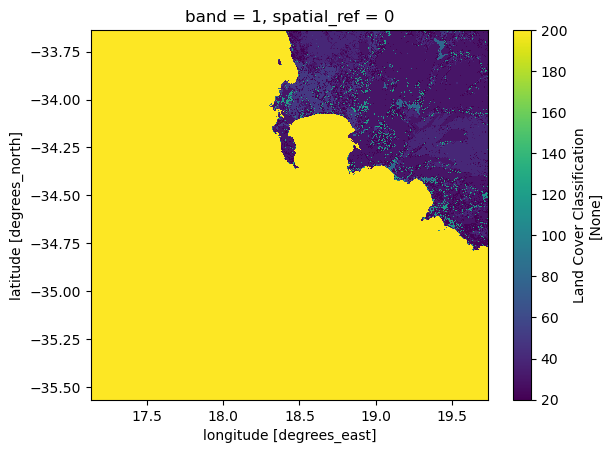

In [16]:
land_cover.squeeze().rio.clip_box(*cloud_dist.rio.reproject("EPSG:4326").rio.bounds()).plot.imshow()

### Auxiliary Data
#### Biome Clusters

In [5]:
import geopandas as gpd

In [8]:
# biome clusters
# see https://zenodo.org/record/5848610#.ZEZ4Py-21qs
biome_clusters = gpd.read_file("/Users/felixschulz/Library/CloudStorage/OneDrive-Persönlich/Dokumente/Uni/Master Thesis/data/biome clusters/biome_cluster_shapefile/ProbaV_UTM_LC100_biome_clusters_V3_global.shp")

<Axes: >

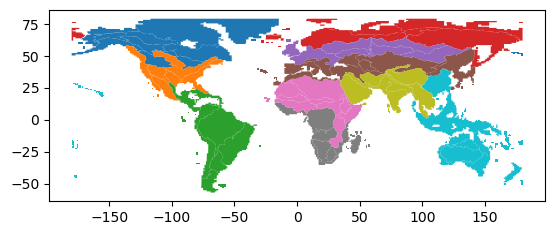

In [14]:
biome_clusters.plot(column = "bc_id")

#### Elevation

In [15]:
import xarray as xr
import rioxarray as rxr

In [17]:
# https://www.usgs.gov/centers/eros/science/usgs-eros-archive-digital-elevation-shuttle-radar-topography-mission-srtm-1
elevation = rxr.open_rasterio("/Users/felixschulz/Library/CloudStorage/OneDrive-Persönlich/Dokumente/Uni/Master Thesis/data/DTM/srtm_40_19/srtm_40_19.tif")

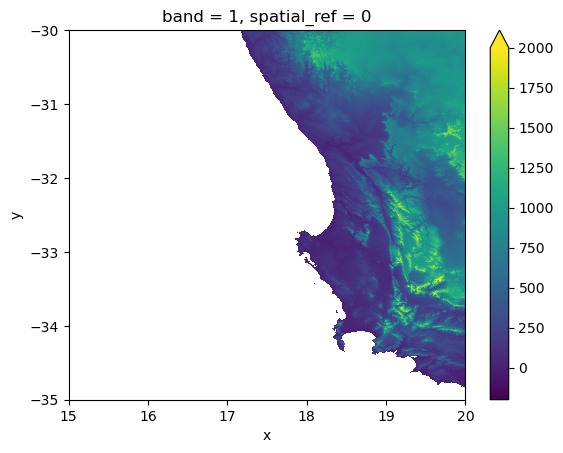

In [20]:
elevation.where(elevation >= -200).squeeze().plot.imshow(vmin = -200, vmax = 2000)

#### Combining for ML

In [1]:
import numpy as np
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
import shapely
import re
import pandas as pd
import geopandas as gpd
import multiprocessing
import datetime
root_dir = "/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/Masterthesis/"

/scratch/slurm_tmpdir/job_22166552/ipykernel_677703/3861784082.py:4: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [11]:
files = os.listdir("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/Masterthesis/data/imagery/za_ls45_2015")

In [12]:
files_stems = list(set([re.compile(".*(?=\_02\_T[12])").search(file).group(0) for file in files]))

In [13]:
index_df = gpd.GeoDataFrame(dict(file_stem = files_stems,
                 date = pd.to_datetime([re.compile("2015\d+").search(file_stem).group(0) for file_stem in files_stems])))

In [179]:
re_LL, re_UR = re.compile("(?<=LL_CORNER = \(\s).*(?=\))"), re.compile("(?<=UR_CORNER = \(\s).*(?=\))")
re_DAT, re_PROJ, re_ZONE = re.compile("(?<=DATUM \= \").*(?=\")"), re.compile("(?<=MAP\_PROJECTION \= \").*(?=\")"), re.compile("(?<=UTM\_ZONE \= ).*(?=\n)")
re_EPYEAR, re_EPDAY, re_EPSECS = re.compile("(?<=EPHEMERIS\_EPOCH\_YEAR \= )\d+"), re.compile("(?<=EPHEMERIS\_EPOCH\_DAY \= )\d+"), re.compile("(?<=EPHEMERIS\_EPOCH\_SECONDS \= )\d+")
    
def worker(path):
    try:
        with open(root_dir + "data/imagery/za_ls45_2015/" + path + "_02_T1_ANG.txt", "r") as file:
            tmp = file.read()
    except:
        with open(root_dir + "data/imagery/za_ls45_2015/" + path + "_02_T2_ANG.txt", "r") as file:
            tmp = file.read()
    finally:
        x_min, y_min = pd.Series([float(x) for x in re_LL.findall(tmp)[0].split(", ")])
        x_max, y_max = pd.Series([float(x) for x in re_UR.findall(tmp)[0].split(", ")])
        
        ep_year = re_EPYEAR.search(tmp).group(0)
        ep_day = re_EPDAY.search(tmp).group(0)
        ep_secs = float(re_EPSECS.search(tmp).group(0))
        
        crs_datum = re_DAT.search(tmp).group(0)
        crs_projection = re_PROJ.search(tmp).group(0)
        crs_utm_zone = re_ZONE.search(tmp).group(0)
        
        return pd.Series({"geometry": shapely.Polygon([[x_min, y_min],
                                                       [x_min, y_max],
                                                       [x_max, y_max],
                                                       [x_max, y_min]]),
                          "time": datetime.datetime.strptime(f"{ep_year}-{ep_day}", "%Y-%j") + datetime.timedelta(seconds = ep_secs),
                          "CRS": f"{crs_datum}/{crs_projection}/{crs_utm_zone}"})
    

In [177]:
datetime.datetime.strptime(f"{ep_year}-{ep_day}", "%Y-%j") + datetime.timedelta(seconds = ep_secs)

datetime.datetime(2015, 1, 6, 7, 42, 6)

In [180]:
index_df[["geometry", "time", "CRS"]] = index_df.file_stem.apply(worker)

In [16]:
crs_lookup = {"WGS84/UTM/33": 32633,
              "WGS84/UTM/34": 32634,
              "WGS84/UTM/35": 32635,
              "WGS84/UTM/36": 32636}

out_df = index_df[:0].copy().set_crs(32332)
for crs in index_df.CRS.unique():
    tmp = index_df[index_df.CRS == crs].copy()
    tmp = tmp.set_crs(crs_lookup[crs]).to_crs(32332)
    out_df = pd.concat([out_df, tmp])

In [5]:
boundaries = gpd.read_file(root_dir + "data/boundaries/gadm_za.gpkg").to_crs(32332)

In [6]:
xmin, ymin, xmax, ymax = boundaries.total_bounds

length = 2000 * 30
wide = 2000 * 30

cols = list(np.arange(xmin, xmax + wide, wide))
rows = list(np.arange(ymin, ymax + length, length))

polygons = []
for x in cols[:-1]:
    for y in rows[:-1]:
        polygons.append(shapely.Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))
        
grid = gpd.GeoDataFrame({'geometry': polygons}, crs = 32332)
grid = grid[grid.intersects(boundaries.geometry.iloc[0])]

NameError: name 'out_df' is not defined

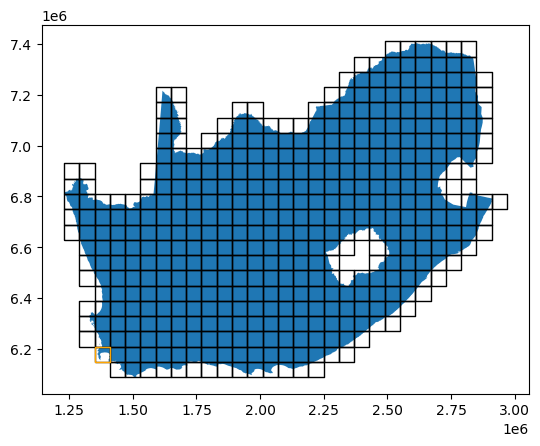

In [7]:
ax = boundaries.plot()
grid.plot(color = "none", edgecolor='black', ax = ax)
grid.iloc[[16],:].plot(color = "none", edgecolor='orange', ax = ax)
out_df[:10].plot(color = "none", edgecolor='red', ax = ax)

In [128]:
tmp = grid.iloc[16].geometry.exterior.coords
grid_xr = xr.DataArray(data = np.zeros((2000, 2000, 3)),
                       dims = ["x","y","band"],
                       coords = {"x": np.round(np.linspace(tmp[0][0], tmp[1][0], 2000)),
                                 "y": np.round(np.linspace(tmp[0][1], tmp[2][1], 2000)),
                                 "band": ["blue", "green", "red"]})
grid_xr = grid_xr.rio.write_crs(32332)

In [53]:
query_images = out_df[out_df.intersects(grid.iloc[16].geometry)].sort_values("date", ascending = False)["file_stem"]

In [164]:
test = []
for i in range(10):
    it_t = 1
    if not os.path.exists(f"{root_dir}data/imagery/za_ls45_2015/{query_images.iloc[i]}_02_T1_SR_CLOUD_QA.TIF"):
        it_t = 2
    red = rxr.open_rasterio(f"{root_dir}data/imagery/za_ls45_2015/{query_images.iloc[i]}_02_T{it_t}_SR_B3.TIF")
    test += [red.mean().values.tolist()]

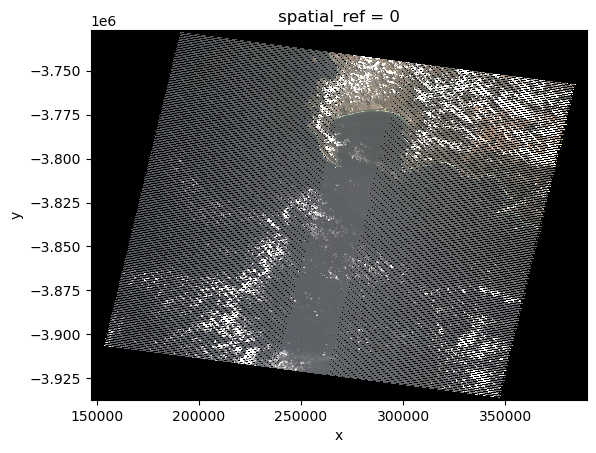

In [169]:
i = 1
red = rxr.open_rasterio(root_dir + f"data/imagery/za_ls45_2015/{query_images.iloc[i]}_02_T1_SR_B3.TIF")
green = rxr.open_rasterio(root_dir + f"data/imagery/za_ls45_2015/{query_images.iloc[i]}_02_T1_SR_B2.TIF")
blue = rxr.open_rasterio(root_dir + f"data/imagery/za_ls45_2015/{query_images.iloc[i]}_02_T1_SR_B1.TIF")
imagery = xr.combine_nested([red, green, blue], concat_dim = "band")
xr.plot.imshow(imagery, rgb = "band", robust = True)

In [166]:
test

[13652.144960103216,
 5873.560585794334,
 10593.894985736908,
 12170.578399197677,
 6419.332230864268,
 5082.566453960201,
 6773.848246696734,
 9921.449836335181,
 16692.777152724888,
 9357.508820333138]

In [142]:
query_images

937     LE07_L2SP_174084_20151225_20200903
672     LE07_L2SP_175084_20151216_20200903
402     LE07_L2SP_175083_20151216_20200903
773     LE07_L2SP_174084_20151209_20200903
111     LE07_L2SP_175083_20151130_20200903
1034    LE07_L2SP_175084_20151130_20200903
793     LE07_L2SP_174084_20151123_20200903
966     LE07_L2SP_175083_20151114_20200903
123     LE07_L2SP_175084_20151114_20200903
566     LE07_L2SP_174084_20151107_20200903
578     LE07_L2SP_175084_20151029_20200903
1097    LE07_L2SP_175083_20151029_20200903
1014    LE07_L2SP_174084_20151022_20200903
935     LE07_L2SP_174084_20150904_20200903
1262    LE07_L2SP_175084_20150810_20200904
651     LE07_L2SP_175083_20150810_20200904
443     LE07_L2SP_174084_20150803_20200904
1058    LE07_L2SP_175083_20150725_20200904
626     LE07_L2SP_174084_20150718_20200904
766     LE07_L2SP_174084_20150702_20200904
1237    LE07_L2SP_175083_20150607_20200904
1002    LE07_L2SP_175084_20150607_20200904
1086    LE07_L2SP_175084_20150506_20200905
927     LE0

In [133]:
na_share = 1
it_image = 0

while na_share > .02:
    it_stem = query_images.iloc[it_image]
    
    it_t = 1
    if not os.path.exists(f"{root_dir}data/imagery/za_ls45_2015/{it_stem}_02_T1_SR_CLOUD_QA.TIF"):
        it_t = 2
    
    cloud_mask = rxr.open_rasterio(f"{root_dir}data/imagery/za_ls45_2015/{it_stem}_02_T{it_t}_SR_CLOUD_QA.TIF")
    red = rxr.open_rasterio(f"{root_dir}data/imagery/za_ls45_2015/{it_stem}_02_T{it_t}_SR_B3.TIF")
    green = rxr.open_rasterio(f"{root_dir}data/imagery/za_ls45_2015/{it_stem}_02_T{it_t}_SR_B2.TIF")
    blue = rxr.open_rasterio(f"{root_dir}data/imagery/za_ls45_2015/{it_stem}_02_T{it_t}_SR_B1.TIF")
    
    red_filtered = red.where((np.logical_not(cloud_mask.isin([2, 34, 8, 12, 24, 40, 56])) & (red != 0))).squeeze()
    red_filtered = red_filtered.rio.reproject(32332)
    green_filtered = green.where((np.logical_not(cloud_mask.isin([2, 34, 8, 12, 24, 40, 56])) & (green != 0))).squeeze()
    green_filtered = green_filtered.rio.reproject(32332)
    blue_filtered = blue.where((np.logical_not(cloud_mask.isin([2, 34, 8, 12, 24, 40, 56])) & (blue != 0))).squeeze()
    blue_filtered = blue_filtered.rio.reproject(32332)
    
    it_coords = grid_xr.rio.clip([out_df.loc[out_df.file_stem == it_stem, "geometry"].iloc[0]])
    
    for x_coord in it_coords.x.values:
        for band in ["blue", "green", "red"]:
            query_yvals = it_coords.y.values[((grid_xr.loc[{"x": x_coord, "y": it_coords.y.values, "band": band}] == 0) |
                                              grid_xr.loc[{"x": x_coord, "y": it_coords.y.values, "band": band}].isnull())]
            exec(f'query_vals = {band}_filtered.sel(x = x_coord, y = query_yvals, method = "nearest", tolerance = 30).values')
            grid_xr.loc[{"x": x_coord, "y": query_yvals, "band": band}] = query_vals
    
    na_share = (((grid_xr == 0) | grid_xr.isnull()).sum() / 3) / (grid_xr.shape[0] * grid_xr.shape[1])
    it_image += 1

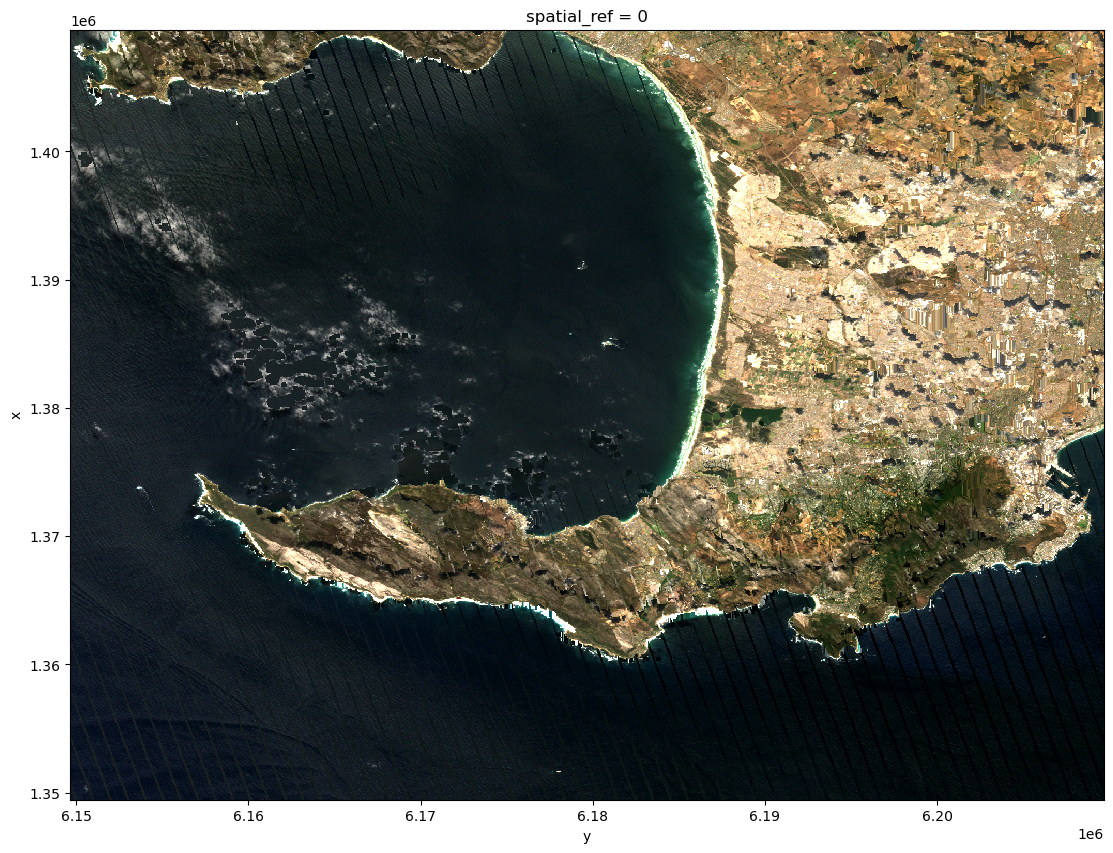

In [141]:
grid_xr.copy().where(((grid_xr > 0) & (grid_xr <= 60000))).ffill("x").loc[{"band": ["red", "green", "blue"]}].plot.imshow(size = 10, rgb = "band", robust = True)

In [43]:
cloud_mask = rxr.open_rasterio(root_dir + "data/imagery/za_ls45_2015/LE07_L2SP_175083_20151216_20200903_02_T1_SR_CLOUD_QA.TIF")
red = rxr.open_rasterio(root_dir + "data/imagery/za_ls45_2015/LE07_L2SP_175083_20151216_20200903_02_T1_SR_B3.TIF")

In [45]:
red_filtered = red.where((np.logical_not(cloud_mask.isin([2, 34])) & (red != 0))).squeeze()
red_filtered = red_filtered.rio.reproject(32332)

In [47]:
tmp = grid_xr.rio.clip([out_df.loc[out_df.file_stem == "LE07_L2SP_175083_20151216_20200903", "geometry"].iloc[0]])

In [48]:
for x_coord in tmp.x.values:
    grid_xr.loc[{"x": x_coord, "y": tmp.y.values}] = red_filtered.sel(x = x_coord, y = tmp.y.values, method = "nearest", tolerance = 30).values

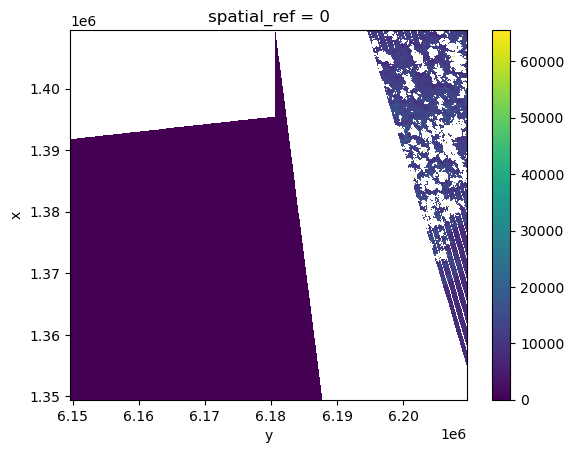

In [50]:
grid_xr.plot.imshow()

In [13]:
from itertools import product

In [16]:
grid_coords = np.array([[(x, y) for x in grid_xr.x.values] for y in grid_xr.y.values])
imagery_coords = np.array([[(x, y) for x in red_filtered.x.values] for y in red_filtered.y.values])

In [22]:
from scipy.spatial.distance import cdist
test = [[cdist(grid_coords[i], imagery_coords[j]) for i in range(grid_coords.shape[0])] for j in range(imagery_coords.shape[0])]

In [22]:
for x_coord in tmp.x.values:
    for y_coord in tmp.y.values:
        if not tmp.loc[{"x": x_coord, "y": y_coord}].isnull():
            grid_xr.loc[{"x": x_coord, "y": y_coord}] = red_filtered.sel(x = x_coord, y = y_coord, method = "nearest", tolerance = 30)

KeyboardInterrupt: 

In [14]:
with Pool(4) as p:
    

IndentationError: expected an indented block (1567658966.py, line 2)

In [6]:
red = rxr.open_rasterio(root_dir + "data/imagery/LE07_L2SP_167078_20150106_20200905_02_T1/LE07_L2SP_167078_20150106_20200905_02_T1_SR_B3.TIF")
green = rxr.open_rasterio(root_dir + "data/imagery/LE07_L2SP_167078_20150106_20200905_02_T1/LE07_L2SP_167078_20150106_20200905_02_T1_SR_B2.TIF")
blue = rxr.open_rasterio(root_dir + "data/imagery/LE07_L2SP_167078_20150106_20200905_02_T1/LE07_L2SP_167078_20150106_20200905_02_T1_SR_B1.TIF")
NIR = rxr.open_rasterio(root_dir + "data/imagery/LE07_L2SP_167078_20150106_20200905_02_T1/LE07_L2SP_167078_20150106_20200905_02_T1_SR_B4.TIF")
SWIR = rxr.open_rasterio(root_dir + "data/imagery/LE07_L2SP_167078_20150106_20200905_02_T1/LE07_L2SP_167078_20150106_20200905_02_T1_SR_B5.TIF")
MIR = rxr.open_rasterio(root_dir + "data/imagery/LE07_L2SP_167078_20150106_20200905_02_T1/LE07_L2SP_167078_20150106_20200905_02_T1_SR_B7.TIF")

In [7]:
imagery = xr.combine_nested([green, red, blue, NIR, SWIR, MIR], concat_dim = "band")

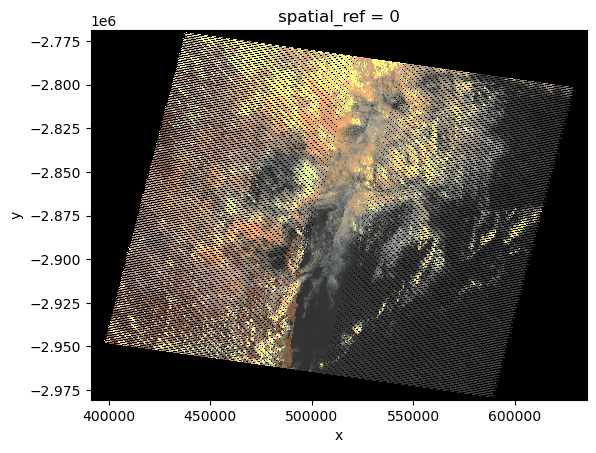

In [17]:
xr.plot.imshow(imagery[3:,:,:], rgb = "band", robust = True)